# Regularization and Hyperparameter Tuning using Fashion-MNIST

**Author**: Tianxiang (Adam) Gao <br>
**Course**: CSC 383 / 483 – Applied Deep Learning <br>
**Description**:  
In this assignment, you will explore how neural networks can **overfit** training data and how **regularization** techniques such as dropout and weight decay can improve **generalization**.

You will also experiment with **hyperparameter tuning**, adjusting parameters like the learning rate and dropout rate to find combinations that lead to better model performance.


## Setup

We will first import some useful libraries:
- `numpy` for numerical operations (e.g., arrays, random sampling).
- `keras` for loading the MNIST dataset and building deep learning models.
- `keras.layers` provides the building blocks (dense layers, convolutional layers, activation functions, etc.) to design neural networks.
- `matplotlib` for visualizing images and plotting graphs.
- `sklearn.model_selection` for splitting a validation set from the training data.

In [17]:
import numpy as np
import keras
from keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Prepare the Data [0/0]

1. Use `keras.datasets.fashion_mnist.load_data()` to load the **Fashion-MNIST** training and test sets.  
2. Normalize all pixel values from integers in the range **[0, 255]** to floating-point numbers between **0 and 1**.  

In [18]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
y_train_full = y_train_full.squeeze().astype("int32")
x_test = x_test.astype("float32") / 255.0
y_test = y_test.squeeze().astype("int32")
print("x_train shape:", x_train_full.shape)
num_classes, input_shape = 10, x_train_full.shape[1:]
print("num_classes:", num_classes)
print("input_shape:", input_shape)

x_train shape: (60000, 28, 28)
num_classes: 10
input_shape: (28, 28)


## Visualize the Data [0/0]

3. Randomly select **9 images** from the training set `x_train`. Display them in a **3×3 grid** using Matplotlib (`plt.subplot`). For each image, show its corresponding **class label** (from `y_train`) as the subplot title.



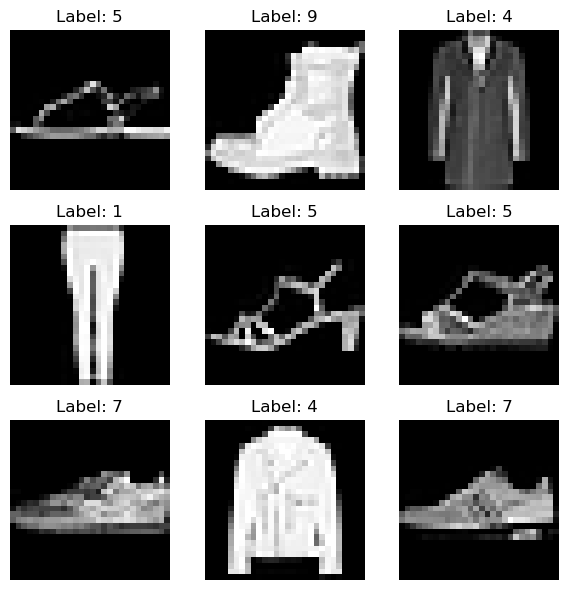

In [19]:
indices = np.random.choice(len(x_train_full), 9, replace=False)

plt.figure(figsize=(6, 6))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_full[idx], cmap="gray")
    # plt.imshow(x_train_full[idx])
    plt.title(f"Label: {y_train_full[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Validation Set [10/10]

4. We will use `train_test_split()` split **50%** of the images from the training dataset to create a **validation set**,  
which will be used to help us **tune the hyperparameters** during training.


In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.5)

print("Train subset:", x_train.shape)
print("Validation subset:", x_val.shape)
print("Test set:", x_test.shape)

Train subset: (30000, 28, 28)
Validation subset: (30000, 28, 28)
Test set: (10000, 28, 28)


## Build the Model [30/30]

5. Implement a helper function `make_model()`  
   that returns a simple **two-layer MLP** built using `keras.Sequential` with the following layers:
   - **Input layer**: accepts images of shape `input_shape`.
   - **Flatten layer**: converts each 2D image into a 1D vector.
   - **Dense layer**: fully connected layer with `width` hidden units and `"relu"` activation.
   - **Dropout layer**: randomly drops a fraction of hidden activations (`dropout_rate`) during training  
     to prevent overfitting. Skip this layer if `dropout_rate = 0`.
   - **Output layer**: fully connected layer with `num_classes` units (one per class) and `"softmax"` activation.


6. Create a `base_model` using your helper function and inspect the model by calling `model.summary()` to display the network architecture, output shapes, and number of parameters in each layer.

7. Save the `initial_weights` of the `base_model` for reuse in optimizer comparisons.


In [21]:
def make_model(num_classes, input_shape, width=128, dropout_rate=0.0):
    model = keras.Sequential([
        layers.Input(input_shape),
        layers.Flatten(),
        layers.Dense(width, activation='relu'),
    ])
    if dropout_rate>0.0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

base_model = make_model(num_classes, input_shape, width=128)
base_model.summary()

initial_weights = base_model.get_weights()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_19 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

## Define Optimizer Function [0/0]

8. To easily switch between different optimization algorithms, copy and paste the helper function  
   `get_optimizer()` from previous assignments.  
   This function should return the corresponding **Keras optimizer object** based on its name.

   Implement the function with the following behavior:
   - `"sgd"` → standard **stochastic gradient descent (SGD)**.  
   - `"momentum"` → **SGD with momentum** (`momentum=0.9`).  
   - `"rmsprop"` → **RMSprop** optimizer (adaptive learning rate).  
   - `"adam"` → **Adam** optimizer (adaptive learning rate with momentum).  
   - Raise a `ValueError` if an unknown name is provided.


In [22]:
def get_optimizer(name, lr=1e-3):
    if name == "sgd":
        return keras.optimizers.SGD(learning_rate=lr)
    elif name == 'momentum':
        return keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif name == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=lr)
    elif name == 'adam':
        return keras.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

## Train and Compare Optimizers [20/20]

9. We will also define a helper function `train()` to train the model using different optimization choices.  
   This function is adapted from previous assignments and includes additional input arguments such as  
   `dropout_rate`, `lr`, and `width`.
   
   The function should:
   - Recreate a **fresh model** via `make_model(...)`.
   - **Reset** to the same `initial_weights` to ensure all optimizers start from the same point.  
   - Build the optimizer using `get_optimizer(name, lr)`.  
   - **Compile** the model with `loss="sparse_categorical_crossentropy"` and `metrics=["accuracy"]`.  
   - **Train** the model on `(x_train, y_train)` and evaluate it using the validation data `(x_val, y_val)`.  
   - **Return** the training `History` object for later comparison.

In [23]:
def train(name, dropout_rate=0.0, lr=1e-3, batch_size=64, width=128, epochs=100):
  model = make_model(num_classes, input_shape, width, dropout_rate)
  model.set_weights(initial_weights)
  opt = get_optimizer(name, lr)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
  print(f"\n===Training with {name}===")
  hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
  return hist

## Experiment: Training with SGD [5/5]

10. Now train your model using **stochastic gradient descent (SGD)** with a high learning rate (`lr=1e-1`) and **no dropout**. This setup will intentionally cause **overfitting** or even unstable training, allowing you to observe how training and validation accuracy diverge.



In [24]:
hist = train("sgd", lr=1e-1)


===Training with sgd===
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7574 - loss: 0.6995 - val_accuracy: 0.8221 - val_loss: 0.5207
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8200 - loss: 0.5141 - val_accuracy: 0.8227 - val_loss: 0.5111
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8307 - loss: 0.4818 - val_accuracy: 0.8260 - val_loss: 0.4873
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8340 - loss: 0.4694 - val_accuracy: 0.8381 - val_loss: 0.4676
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8387 - loss: 0.4600 - val_accuracy: 0.8366 - val_loss: 0.4631
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8396 - loss: 0.4554 - val_accuracy: 0.8368 - val_loss: 0.4662
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8431 - loss: 0.4487 - val_accuracy: 0.8425 - val_loss: 0.4576
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8431 

## Plot Training and Validation Curves [5/5]

11. Define a helper function `plot_history(hist, log_scale=False)` to visualize the **training** and **validation** loss curves from the `History` object returned by `model.fit()`.

    - Plot both **training loss** and **validation loss** on the same graph.  
    - Add axis labels, a title, and a legend for clarity.  
    - Use the optional argument `log_scale=True` to show the loss on a logarithmic scale.


In [25]:
def plot_history(hist, log_scale=False):
  plt.figure(figsize=(8,5))
  plt.plot(hist.history["loss"], color="blue", linestyle="-", label="train")
  plt.plot(hist.history["val_loss"], color="red", linestyle="--", label="val")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()
  plt.grid(True, which="both", ls=":")
  if log_scale:
      plt.yscale("log")
      plt.ylabel("Loss (log scale)")
  plt.show()

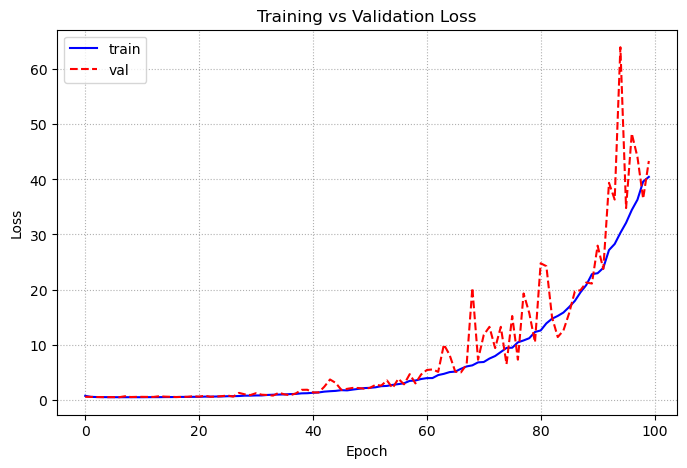

In [26]:
plot_history(hist)

## Experiment: Training with SGD + Dropout [5/5]

12. Now train the model again using **SGD** with the same learning rate (`lr=1e-1`) but add **dropout = 0.5** to apply regularization. Compare the results with the previous run to see how dropout helps reduce overfitting and improves validation performance.


In [27]:
hist = train("sgd", dropout_rate=0.5, lr=1e-1)


===Training with sgd===
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7187 - loss: 0.8012 - val_accuracy: 0.8081 - val_loss: 0.5459
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7896 - loss: 0.6009 - val_accuracy: 0.8172 - val_loss: 0.5286
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7976 - loss: 0.5777 - val_accuracy: 0.8202 - val_loss: 0.5184
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8033 - loss: 0.5601 - val_accuracy: 0.8339 - val_loss: 0.4778
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8042 - loss: 0.5580 - val_accuracy: 0.8284 - val_loss: 0.4788
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8078 - loss: 0.5482 - val_accuracy: 0.8187 - val_loss: 0.5177
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8053 - loss: 0.5544 - val_accuracy: 0.8270 - val_loss: 0.4778
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8054 

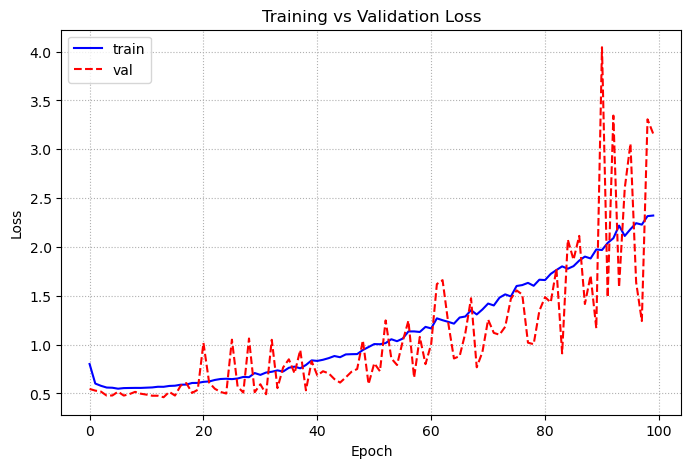

In [28]:
plot_history(hist)

## Hyperparameter Search: Learning Rate vs Dropout [25/25]

13. Now we will perform a simple **grid search** over two important hyperparameters: **Learning rate (`lr`)** and **Dropout rate (`dropout`)**

   For each combination of learning rate and dropout rate:
   - Build a new model using `make_model(...)`.
   - train the model for a fixed number of epochs (e.g. 20) using the **SGD** optimizer
   - and record both  the **training accuracy** and **validation accuracy** from the **last epoch**.

   This will help us visualize which combinations lead to underfitting, overfitting, or the best generalization.


In [29]:
# Define search ranges
import random

learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
dropouts = [0.0, 0.2, 0.5, 0.7]

results = []  # store results in a list of dicts
trials = 10

for lr in learning_rates:
    for drop in dropouts:
        print(f"\nTraining with lr={lr}, dropout={drop}")
        model = make_model(num_classes, input_shape, width=128, dropout_rate=drop)
        model.compile(
            optimizer=keras.optimizers.SGD(learning_rate=lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        hist = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))
        val_acc = hist.history['val_accuracy'][-1]
        train_acc = hist.history['accuracy'][-1]

        print(f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

        results.append([lr, drop, train_acc, val_acc])


Training with lr=0.0001, dropout=0.0
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1927 - loss: 2.3749 - val_accuracy: 0.1916 - val_loss: 2.3277
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2007 - loss: 2.2726 - val_accuracy: 0.2010 - val_loss: 2.2412
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2127 - loss: 2.1977 - val_accuracy: 0.2148 - val_loss: 2.1737
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2285 - loss: 2.1370 - val_accuracy: 0.2308 - val_loss: 2.1171
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2443 - loss: 2.0847 - val_accuracy: 0.2487 - val_loss: 2.0675
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2638 - loss: 2.0381 - val_accuracy: 0.2692 - val_loss: 2.0225
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2846 - loss: 1.9953 - val_accuracy: 0.2913 - val_loss: 1.9809
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.

In [30]:
print("\n=== Summary ===")
print(" lr\t dropout\t train_acc\t val_acc")
for r in results:
    print(f"{r[0]:.0e}\t {r[1]:.1f}\t\t {r[2]:.3f}\t\t {r[3]:.3f}")


=== Summary ===
 lr	 dropout	 train_acc	 val_acc
1e-04	 0.0		 0.545		 0.549
1e-04	 0.2		 0.453		 0.544
1e-04	 0.5		 0.277		 0.435
1e-04	 0.7		 0.254		 0.497
1e-03	 0.0		 0.743		 0.742
1e-03	 0.2		 0.705		 0.736
1e-03	 0.5		 0.669		 0.735
1e-03	 0.7		 0.617		 0.726
1e-02	 0.0		 0.839		 0.831
1e-02	 0.2		 0.823		 0.832
1e-02	 0.5		 0.807		 0.826
1e-02	 0.7		 0.788		 0.822
1e-01	 0.0		 0.855		 0.841
1e-01	 0.2		 0.844		 0.844
1e-01	 0.5		 0.825		 0.842
1e-01	 0.7		 0.806		 0.820


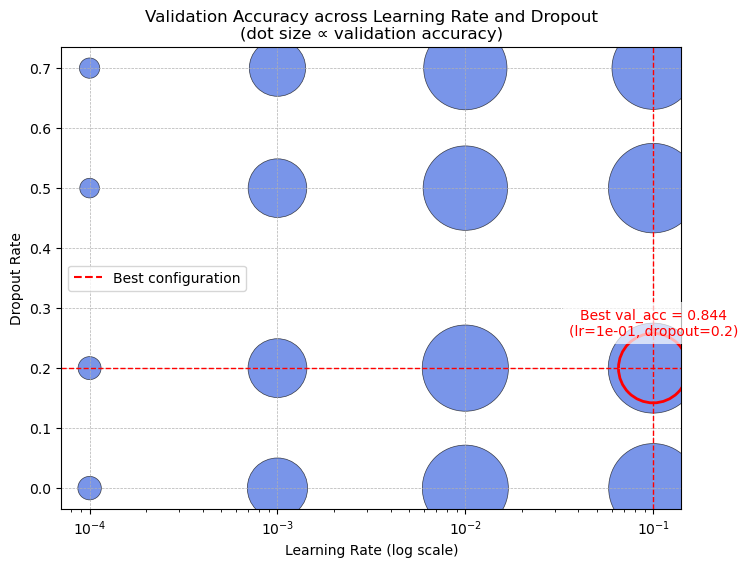

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Convert results to NumPy array
results = np.array(results, dtype=float)
lr = results[:, 0]
drop = results[:, 1]
train_acc = results[:, 2]
val_acc = results[:, 3]

# Normalize validation accuracy to [0, 1]
val_acc_norm = (val_acc - val_acc.min()) / (val_acc.max() - val_acc.min() + 1e-8)

# Exaggerate size differences for visibility
sizes = 200 + 4000 * (val_acc_norm ** 3)

plt.figure(figsize=(8, 6))
plt.scatter(
    lr, drop,
    s=sizes,
    color="royalblue",
    alpha=0.7,
    edgecolors="black",
    linewidths=0.5
)

plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Dropout Rate")
plt.title("Validation Accuracy across Learning Rate and Dropout\n(dot size ∝ validation accuracy)")
plt.grid(True, ls="--", lw=0.5)

# Identify best point
best_idx = np.argmax(val_acc)
best_lr, best_drop, best_val = lr[best_idx], drop[best_idx], val_acc[best_idx]

# Draw dashed guide lines for the best point
plt.axvline(best_lr, color="red", linestyle="--", linewidth=1)
plt.axhline(best_drop, color="red", linestyle="--", linewidth=1)

# Mark the best point with a circle
plt.scatter(best_lr, best_drop, s=2500, facecolors="none", edgecolors="red", linewidths=2)

# Add annotation
plt.text(best_lr, best_drop + 0.05,
         f"Best val_acc = {best_val:.3f}\n(lr={best_lr:.0e}, dropout={best_drop:.1f})",
         color="red", fontsize=10, ha="center", va="bottom",
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# Create a custom line legend handle
custom_line = Line2D([0], [0], color="red", lw=1.5, linestyle="--", label="Best configuration")

# Add legend using the custom line
plt.legend(handles=[custom_line])

plt.show()
